In [1]:
import numpy as np
import tensorflow as tf
from curriculum_learning.models.classifier_model import ClassifierModel
from curriculum_learning import utils
import yaml
from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [2]:
with open("models_hyperparameters.yaml", "r") as stream:
    models_hyperparameters = yaml.safe_load(stream)
    
with open("config_tests.yaml", "r") as stream:
    config_tests = yaml.safe_load(stream)

In [23]:
N_EPOCHS = 30
N_TRIALS = 50
BATCH_SIZE = 512

CONFIG = config_tests["progressive_proba_best"]

loss = tf.keras.losses.SparseCategoricalCrossentropy()

In [24]:
x, y = utils.load_cifar_data("../data/cifar-10-batches-py/")
x /= 255

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=42)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=42)

n_classes = len(np.unique(y))
train_size = x_train.shape[0]

In [25]:
assessment_model = ClassifierModel(output_shape=n_classes, **models_hyperparameters["assessment_model"])

assessment_model.compile(loss=loss, metrics=["accuracy"])
assessment_model(x_train[:1])
assessment_model.load_weights("../models/assessment_model.weights.h5")

In [26]:
assessment_model.evaluate(x_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6241 - loss: 1.0372


[1.029136061668396, 0.6295999884605408]

In [27]:
x_train_sorted = x_train[np.argsort(y_train)]
y_train_sorted = y_train[np.argsort(y_train)]
_, counts = np.unique(y_train_sorted, return_counts=True)

samples_proba = utils.calculate_proba(
    assessment_model, x_train_sorted, y_train_sorted, counts, CONFIG["negative_loss"]
)

In [28]:
model = ClassifierModel(output_shape=n_classes, **models_hyperparameters["test_model_1"])
model.compile(optimizer="adam", loss=loss, metrics=["accuracy"])
model(x_train[0:1])
### model.save_weights("../models/default_model.weights.h5")
model.load_weights("../models/default_model.weights.h5")
model_weights = model.get_weights()

In [29]:
results = {}
model_scores = []

for _ in tqdm(range(N_TRIALS)):
    model.set_weights(model_weights)
        
    for i in range(N_EPOCHS):
        n_samples = int(np.tanh(4 * (i + 1) / N_EPOCHS) * train_size)
        
        samples_ids = utils.chose_samples(n_samples, samples_proba, CONFIG["order_type"])
        model.fit(
            x_train_sorted[samples_ids],
            y_train_sorted[samples_ids],
            # validation_data=(x_val, y_val),
            epochs=1,
            batch_size=BATCH_SIZE,
            verbose=0,
        )
        
        if CONFIG["progressive"]:
            samples_proba = utils.calculate_proba(
                model, x_train_sorted, y_train_sorted, counts, CONFIG["negative_loss"]
            )
            
    _, accuracy = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE, verbose=1)
    model_scores.append(accuracy)

    results["test_model_1"] = model_scores

  0%|          | 0/50 [00:00<?, ?it/s]

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.6610 - loss: 1.0069


  2%|▏         | 1/50 [02:48<2:17:29, 168.37s/it]

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6639 - loss: 0.9891


  4%|▍         | 2/50 [05:00<1:57:29, 146.87s/it]

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6020 - loss: 1.2829


  6%|▌         | 3/50 [07:09<1:48:40, 138.74s/it]

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6734 - loss: 0.9557


  8%|▊         | 4/50 [09:23<1:45:09, 137.16s/it]

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6485 - loss: 1.0635


 10%|█         | 5/50 [11:35<1:41:13, 134.97s/it]

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6298 - loss: 1.1887


 12%|█▏        | 6/50 [13:43<1:37:19, 132.72s/it]

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6468 - loss: 1.0660


 14%|█▍        | 7/50 [15:55<1:34:54, 132.44s/it]

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6411 - loss: 1.0700


 16%|█▌        | 8/50 [18:04<1:32:03, 131.51s/it]

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6369 - loss: 1.1210


 18%|█▊        | 9/50 [20:16<1:29:53, 131.54s/it]

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6543 - loss: 1.0431


 20%|██        | 10/50 [22:24<1:27:03, 130.59s/it]

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6665 - loss: 0.9950


 22%|██▏       | 11/50 [24:32<1:24:14, 129.61s/it]

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5977 - loss: 1.2344


 24%|██▍       | 12/50 [26:38<1:21:23, 128.51s/it]

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6673 - loss: 0.9879


 26%|██▌       | 13/50 [28:44<1:18:45, 127.73s/it]

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6535 - loss: 1.0316


 28%|██▊       | 14/50 [30:49<1:16:08, 126.91s/it]

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5106 - loss: 1.7264


 30%|███       | 15/50 [32:55<1:13:51, 126.61s/it]

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5852 - loss: 1.3232


 32%|███▏      | 16/50 [35:01<1:11:37, 126.41s/it]

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6428 - loss: 1.0789


 34%|███▍      | 17/50 [37:06<1:09:25, 126.22s/it]

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6312 - loss: 1.1321


 36%|███▌      | 18/50 [39:14<1:07:28, 126.50s/it]

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2996 - loss: 3.2535


 38%|███▊      | 19/50 [41:17<1:04:57, 125.72s/it]

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5782 - loss: 1.2166


 40%|████      | 20/50 [43:26<1:03:13, 126.46s/it]

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6485 - loss: 1.0087


 42%|████▏     | 21/50 [45:33<1:01:19, 126.87s/it]

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6461 - loss: 1.0155


 44%|████▍     | 22/50 [47:49<1:00:27, 129.54s/it]

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5815 - loss: 1.2879


 46%|████▌     | 23/50 [50:02<58:46, 130.62s/it]  

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6610 - loss: 0.9824


 48%|████▊     | 24/50 [52:51<1:01:34, 142.10s/it]

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6477 - loss: 1.0249


 50%|█████     | 25/50 [55:08<58:29, 140.36s/it]  

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6626 - loss: 0.9717


 52%|█████▏    | 26/50 [57:25<55:51, 139.64s/it]

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5253 - loss: 1.4973


 54%|█████▍    | 27/50 [59:45<53:29, 139.53s/it]

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6317 - loss: 1.0983


 56%|█████▌    | 28/50 [1:02:07<51:28, 140.37s/it]

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6013 - loss: 1.2349


 58%|█████▊    | 29/50 [1:04:25<48:55, 139.77s/it]

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6493 - loss: 1.0219


 60%|██████    | 30/50 [1:09:29<1:02:55, 188.77s/it]

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6160 - loss: 1.1514


 62%|██████▏   | 31/50 [1:11:48<55:04, 173.90s/it]  

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5953 - loss: 1.1922


 64%|██████▍   | 32/50 [1:14:10<49:19, 164.43s/it]

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6057 - loss: 1.0884


 66%|██████▌   | 33/50 [1:16:30<44:28, 156.94s/it]

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6244 - loss: 1.0802


 68%|██████▊   | 34/50 [1:18:45<40:05, 150.37s/it]

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6696 - loss: 0.9666


 70%|███████   | 35/50 [1:20:55<36:07, 144.48s/it]

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5921 - loss: 1.1503


 72%|███████▏  | 36/50 [1:23:03<32:31, 139.41s/it]

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6019 - loss: 1.2467


 74%|███████▍  | 37/50 [1:25:13<29:34, 136.53s/it]

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6762 - loss: 0.9350


 76%|███████▌  | 38/50 [1:27:34<27:34, 137.89s/it]

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6667 - loss: 0.9818


 78%|███████▊  | 39/50 [1:29:57<25:35, 139.61s/it]

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5844 - loss: 1.3305


 80%|████████  | 40/50 [1:32:20<23:25, 140.54s/it]

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6217 - loss: 1.1652


 82%|████████▏ | 41/50 [1:34:41<21:04, 140.54s/it]

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6528 - loss: 1.0097


 84%|████████▍ | 42/50 [1:36:54<18:27, 138.41s/it]

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6683 - loss: 0.9541


 86%|████████▌ | 43/50 [1:39:06<15:56, 136.58s/it]

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6454 - loss: 0.9924


 88%|████████▊ | 44/50 [1:41:25<13:42, 137.13s/it]

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6402 - loss: 1.0304


 90%|█████████ | 45/50 [1:43:53<11:42, 140.41s/it]

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6422 - loss: 1.0367


 92%|█████████▏| 46/50 [1:46:15<09:23, 140.99s/it]

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6334 - loss: 1.1078


 94%|█████████▍| 47/50 [1:48:35<07:02, 140.77s/it]

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6656 - loss: 0.9920


 96%|█████████▌| 48/50 [1:50:56<04:41, 140.71s/it]

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6466 - loss: 1.0482


 98%|█████████▊| 49/50 [1:53:10<02:18, 138.76s/it]

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6540 - loss: 1.0407


100%|██████████| 50/50 [1:55:29<00:00, 138.60s/it]


In [31]:
sum(results["test_model_1"]) / N_TRIALS

0.6221000009775162

In [11]:
sum(results["test_model_1"]) / N_TRIALS

0.6341319984197616

In [12]:
# import scipy.stats
# scipy.stats.ttest_ind(abc, results["test_model_1"])

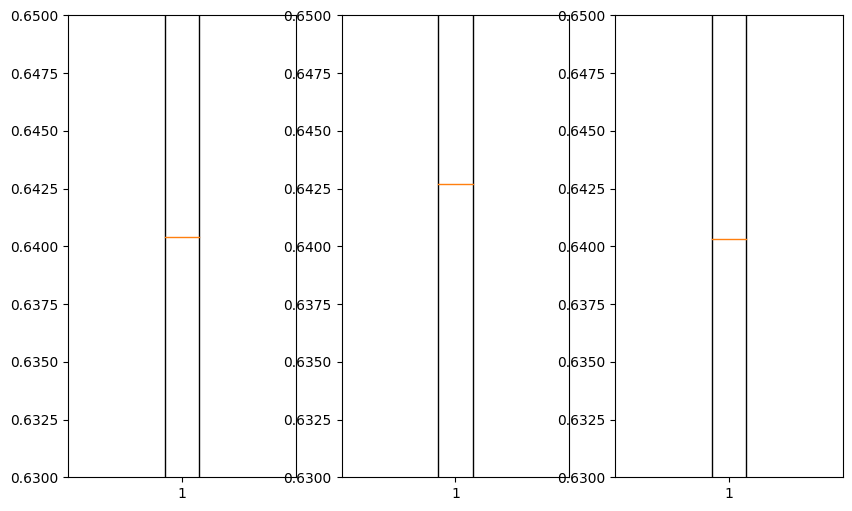

In [48]:
# import matplotlib.pyplot as plt
# plt.figure(figsize=(10, 6))
# plt.subplot(131)
# plt.boxplot(results["test_model_1"])
# plt.ylim([0.63, 0.65])
# plt.subplot(132)
# plt.boxplot(ass_m["test_model_1"])
# plt.ylim([0.63, 0.65])
# plt.subplot(133)
# plt.boxplot(random_m["test_model_1"])
# plt.ylim([0.63, 0.65])
# plt.show()